## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
import os

from PIL import Image 
import cv2

from sklearn.model_selection import train_test_split

from tqdm import tqdm

#import tensorflow
import keras
from keras.models import Model
from keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Dense, Flatten

from warnings import filterwarnings
filterwarnings('ignore')


Using TensorFlow backend.


### Load Dataset Files

In [2]:
# Mount the drive for loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# walk-through/browse the un-zipped folder
!ls "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification"

DS  labels.csv.zip  sample_submission.csv.zip  test.zip  train.zip


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

#### The below zip is commented as it is un-zipped once only and required repeatedly execute it whenver the session starts

In [0]:
#with ZipFile(project_path+'train.zip', 'r') as train_z:
#  train_z.extractall(path=project_path+'DS')

Repeat the same step for test.zip

In [0]:
#with ZipFile(project_path+'test.zip', 'r') as test_z:
#  test_z.extractall(path=project_path+'DS')

Repeat the same step for sample_submission.csv.zip

In [0]:
#with ZipFile(project_path+'sample_submission.csv.zip', 'r') as sample_submission_z:
#  sample_submission_z.extractall(path=project_path+'DS')

Repeat the same step for labels.csv.zip

In [0]:
#with ZipFile(project_path+'labels.csv.zip', 'r') as labels_z:
#  labels_z.extractall(path=project_path+'DS')

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

In [9]:
!ls "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/DS"

labels.csv	       test   vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
sample_submission.csv  train


### Read labels.csv file using pandas

In [0]:
labels = pd.read_csv(project_path+'DS/labels.csv')

In [11]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# Gives the no of unique dog breed in the given data-set
labels.nunique()

id       10222
breed      120
dtype: int64

In [13]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


### Print the count of each category of Dogs given in the dataset



In [14]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,fa79fd049300f5082393fa99a142cd7f,scottish_deerhound
freq,1,126


In [15]:
# top 10 breed (with higher counts in the data set)
labels['breed'].value_counts().head(10)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

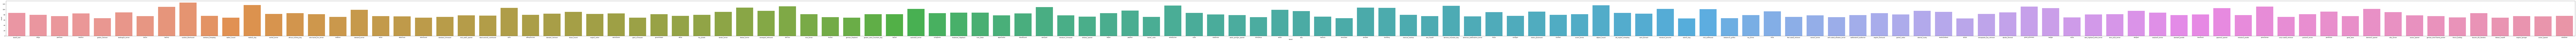

In [16]:
# visual presentation of each breed thru countplot
fig, ax = plt.subplots(1,1,figsize=(360,5))
sns.countplot(x=labels['breed'],ax=ax)
plt.show()

In [17]:
no_of_ds_img = !find "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/DS/train" -type f -print | wc -l
files = !ls "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/DS/train" | head -5
print('No of files in train DS{}\n'.format(no_of_ds_img))
print('list few files from train DS\n',files)

No of files in train DS['10222']

list few files from train DS
 ['000bec180eb18c7604dcecc8fe0dba07.jpg', '001513dfcb2ffafc82cccf4d8bbaba97.jpg', '001cdf01b096e06d78e9e5112d419397.jpg', '00214f311d5d2247d5dfe4fe24b2303d.jpg', '0021f9ceb3235effd7fcde7f7538ed62.jpg']


In [18]:
no_of_ds_img = !find "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/DS/test" -type f -print | wc -l
files = !ls "/content/drive/My Drive/1.Dataset/Dog_Breed_Identification/DS/test" | head -5
print('No of files in test DS{}\n'.format(no_of_ds_img))
print('list few files from test DS\n',files)

No of files in test DS['2952']

list few files from test DS
 ['000621fb3cbb32d8935728e48679680e.jpg', '00102ee9d8eb90812350685311fe5890.jpg', '0012a730dfa437f5f3613fb75efcd4ce.jpg', '001510bc8570bbeee98c8d80c8a95ec1.jpg', '001a5f3114548acdefa3d4da05474c2e.jpg']


### Get one-hot encodings of labels

In [0]:
ohe = pd.get_dummies(labels['breed'])

In [0]:
labels = pd.concat([labels, ohe], axis=1, sort=False)

In [21]:
labels.head(3)

,id,breed,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001cdf01b096e06d78e9e5112d419397,pekinese,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [22]:
train_feature = []
img_rows = 224 #64
img_cols = 224 #64

for breed_id, breed_label in tqdm(labels.values[:,:2]):
    img = cv2.imread(project_path+'DS/train/'+'{}.jpg'.format(breed_id))
    img = img_to_array(img)
    img = cv2.resize(img, (img_rows, img_cols)) 
    train_feature.append(img)
    

100%|██████████| 10222/10222 [01:34<00:00, 108.35it/s]


In [0]:
train_feature = np.asarray(train_feature) / 255

In [24]:
train_feature.shape

(10222, 224, 224, 3)

In [0]:
train_target = labels.values[:,2:]

In [26]:
train_target.shape

(10222, 120)

In [0]:
idx_range = np.random.randint(low=0,high=train_feature.shape[0],size=3)

#for idx in idx_range:
  #plt.imshow(train_feature[idx])
  #plt.show()

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_feature,train_target,test_size=0.25,random_state=3,)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
#sample_submission =  pd.read_csv(project_path+'DS/sample_submission.csv',usecols=['id'])
sample_submission =  pd.read_csv(project_path+'DS/sample_submission.csv')

In [30]:
sample_submission.head(3)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [31]:
sample_submission.shape

(10357, 121)

Run the below code to load the test image files in x_test_feature

In [32]:
x_test_feature = []
test_img_count = 0

for f, b in tqdm(sample_submission.values[:,:2]):
  img = cv2.imread(project_path+'DS/test/'+'{}.jpg'.format(f),0) 
  if img is not None:
    img = img_to_array(img)
    img = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img)
    test_img_count +=1
    

100%|██████████| 10357/10357 [16:16<00:00, 10.61it/s]  


In [33]:
test_img_count

2952

Normalize the test data and convert it into 4 dimensions

In [0]:
test_img = np.asarray(x_test_feature) /255

In [35]:
test_img.shape

(2952, 224, 224)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [36]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(5,5),input_shape=(img_rows,img_cols,3),data_format='channels_last'))
model.add(Activation('relu'))

model.add(AveragePooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(AveragePooling2D(pool_size=(2,2)))

model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Dense(120))
model.add(Activation('softmax'))

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 8)       608       
_________________________________________________________________
activation_1 (Activation)    (None, 220, 220, 8)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 110, 110, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 8)       32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 16)      1168

In [37]:
#opt = keras.optimizers.sgd(lr=0.001, momentum=0.2)

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt,loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


### Use batch_size = 128 and epochs = 10 and execute the model

In [38]:
m_his = model.fit(x=x_train,y=y_train, validation_data=(x_test,y_test), batch_size=128, epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7666 samples, validate on 2556 samples
Epoch 1/10
7666/7666 [==============================] - 61s 8ms/step - loss: 7.5262 - acc: 0.0111 - val_loss: 5.5263 - val_acc: 0.0110
Epoch 2/10
7666/7666 [==============================] - 60s 8ms/step - loss: 5.0397 - acc: 0.1186 - val_loss: 5.2672 - val_acc: 0.0192
Epoch 3/10
7666/7666 [==============================] - 61s 8ms/step - loss: 3.6710 - acc: 0.2845 - val_loss: 5.0967 - val_acc: 0.0239
Epoch 4/10
7666/7666 [==============================] - 60s 8ms/step - loss: 2.1169 - acc: 0.5307 - val_loss: 5.1562 - val_acc: 0.0203
Epoch 5/10
7666/7666 [==============================] - 60s 8ms/step - loss: 1.0327 - acc: 0.7469 - val_loss: 5.5764 - val_acc: 0.0243
Epoch 6/10
7666/7666 [==============================] - 60s 8ms/step - loss: 0.4842 - acc: 0.8770 - val_loss: 5.9756 - val_acc: 0.0317
Epoch 7/10
7666/7666 [========================

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
# define data preparation
train_datagen = ImageDataGenerator(featurewise_center=True, 
                         		featurewise_std_normalization=True,
														rotation_range=20,
		                        zoom_range=0.15,
		                        width_shift_range=0.2,
		                        height_shift_range=0.2,
		                        shear_range=0.15,
		                        fill_mode="nearest")

val_datagen = ImageDataGenerator(featurewise_center=True, 
                         		featurewise_std_normalization=True,
														rotation_range=20,
		                        zoom_range=0.15,
		                        width_shift_range=0.2,
		                        height_shift_range=0.2,
		                        shear_range=0.15,
		                        fill_mode="nearest")

In [0]:
# fit parameters from data
train_datagen.fit(x_train)
val_datagen.fit(x_test)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = train_datagen.flow(x_train, y_train)
val_generator = train_datagen.flow(x_test, y_test)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [42]:
model.fit_generator(generator=train_generator,validation_data=val_generator, epochs=10)

Epoch 1/10
240/240 [==============================] - 121s 504ms/step - loss: 5.3003 - acc: 0.0086 - val_loss: 6.2377 - val_acc: 0.0102
Epoch 2/10
240/240 [==============================] - 116s 483ms/step - loss: 4.7842 - acc: 0.0104 - val_loss: 4.7857 - val_acc: 0.0117
Epoch 3/10
240/240 [==============================] - 118s 494ms/step - loss: 4.7848 - acc: 0.0125 - val_loss: 4.7847 - val_acc: 0.0121
Epoch 4/10
240/240 [==============================] - 119s 496ms/step - loss: 4.7797 - acc: 0.0108 - val_loss: 4.7848 - val_acc: 0.0121
Epoch 5/10
240/240 [==============================] - 117s 487ms/step - loss: 4.7785 - acc: 0.0125 - val_loss: 4.7847 - val_acc: 0.0121
Epoch 6/10
240/240 [==============================] - 118s 494ms/step - loss: 4.7778 - acc: 0.0124 - val_loss: 4.7848 - val_acc: 0.0121
Epoch 7/10
240/240 [==============================] - 117s 487ms/step - loss: 4.7767 - acc: 0.0124 - val_loss: 4.7861 - val_acc: 0.0121
Epoch 8/10
240/240 [============================

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [43]:
from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=(project_path+'DS/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'), include_top=False, input_shape = (224,224,3))

Print the summary of the base_model

In [44]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [45]:
# add new classifier layers
flat_op = Flatten()(base_model.output)

D1_op = Dense(1024, activation='relu')(flat_op)
D2_op = Dense(256, activation='relu')(D1_op)

fin_output = Dense(120, activation='softmax')(D2_op)

# define new model
TL_model = Model(inputs=base_model.inputs, outputs=fin_output)

TL_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
for layer in TL_model.layers:
  if ( layer.name.find('conv') >= 0 ):
    layer.trainable = False
  

In [47]:
TL_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
TL_model.compile(optimizer=opt,loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [49]:
tl_m_his = TL_model.fit(x=x_train,y=y_train, validation_data=(x_test,y_test), batch_size=128, epochs=10)

Train on 7666 samples, validate on 2556 samples
Epoch 1/10
7666/7666 [==============================] - 286s 37ms/step - loss: 5.0131 - acc: 0.0111 - val_loss: 4.7601 - val_acc: 0.0223
Epoch 2/10
7666/7666 [==============================] - 284s 37ms/step - loss: 4.6470 - acc: 0.0267 - val_loss: 4.5988 - val_acc: 0.0344
Epoch 3/10
7666/7666 [==============================] - 286s 37ms/step - loss: 4.2964 - acc: 0.0685 - val_loss: 4.2463 - val_acc: 0.0689
Epoch 4/10
7666/7666 [==============================] - 285s 37ms/step - loss: 3.5998 - acc: 0.1582 - val_loss: 3.7452 - val_acc: 0.1377
Epoch 5/10
7666/7666 [==============================] - 282s 37ms/step - loss: 2.8032 - acc: 0.2939 - val_loss: 3.4117 - val_acc: 0.1811
Epoch 6/10
7666/7666 [==============================] - 283s 37ms/step - loss: 2.1606 - acc: 0.4318 - val_loss: 3.3633 - val_acc: 0.2042
Epoch 7/10
7666/7666 [==============================] - 283s 37ms/step - loss: 1.5965 - acc: 0.5839 - val_loss: 3.2803 - val_acc: 

### Inferences:

The accuracy score is very low even after using transfer learning method. Using VGG16 (as requested in the assignment)
not able to improve the accruacy.

Request the concern team to review & let know what is missed and how could the accuracy be improved using VGG16 
for the mentioned NN. 


### EOF